In [3]:
import tweepy
from datetime import datetime
from dateutil.parser import parse
from IPython.display import clear_output
import json
import pandas as pd
from time import sleep
import datetime
import os
from textblob import TextBlob
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
#import twitter apps configaration file from config.py file
from config import keys as k
import operator
#list of players 
Players=["STRIKER_OW","blaseOW","aimgod_ow","KellexOW","HarryHook","MickiePP",
        "DF_aKm","uNKOE","OGE_ow","HAGOPEUN_OW","minon501","MisfitsTviQuE","xepher123",
        "Apply","Muma","BaniOW","Forceboink","LiNkzrOW","coolmatt69","Birdring","Anamo_ow","tf2pine",
        "Mano_OWL","Boombox","carpe_ow","snillo_ow","SADO_OW","smurf_ow","moth_ow","Shock_CHB","karivow",
        "super_OW","KING_BABYBAY" ,"BdosinOW","NUS_OW","Furyy_d","Surefour","BischuGG", "Shaz_OW","Hydration",
        "spaceOW","Custa","agilities","Fate_ow","saebyeolbe","MekOppa","GamsuOW"]
#list of teams with there cosponding players
Teams={ "Boston Uprising":["GamsuOW","STRIKER_OW","blaseOW","aimgod_ow","KellexOW"],
       "Dallas Fuel":["HarryHook","MickiePP","DF_aKm","uNKOE","OGE_ow"],
       "Florida Myham":["HAGOPEUN_OW","minon501","MisfitsTviQuE","xepher123", "Apply"],
       "Outlaws":["Muma","BaniOW","Forceboink","LiNkzrOW","coolmatt69"],
        "London Spitfire":["Birdring","BdosinOW","NUS_OW","Furyy_d"],
        "LA Glad":["Surefour","BischuGG", "Shaz_OW","Hydration"],
        "LA Val":["karivow","spaceOW","Custa","agilities","Fate_ow"],
        "New York Excel":["saebyeolbe","MekOppa","Anamo_ow","tf2pine","Mano_OWL"],
        "PHILADELPHIA FUSION":["Boombox","carpe_ow","snillo_ow","SADO_OW"],
        "SAN FRANCISCO SHOCK":["smurf_ow","moth_ow","Shock_CHB","super_OW","KING_BABYBAY"]}


### Before running be sure to have your own config.py with keys

In [4]:
class tweets():
    def __init__(self,keys):
        #Authentication using keys & accesstoken
        auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)
        auth.set_access_token(keys.access_token, keys.access_token_secret)
        self.api = tweepy.API(auth)

    def get_realtions(self,user_id,fo,fr):
    #Method Gets both followers and friends of a user
    #user_id=twitters users name, fo= follower grab limit, fr= Friend grab limit
        df= pd.DataFrame(columns=['from','to','created_at'])
        tmplst=[]
        x=0
        for user in tweepy.Cursor(self.api.followers, screen_name=user_id).items(fo):
        #Gets users followers using api Stoping every 270 to take a 15 minute break so not to over pull
            if x==270:
                print ('[-] Timeout, sleeping for 15 minutes...',len(tmplst))
                sleep(15*60)
                x=0
            clear_output()
            tmplst.append({ 'from':user.screen_name,
                            'to':user_id,
                            'created_at':user.created_at})
            print('Followers:',(round(((len(tmplst)/fo)*100),2)),'%')# Displays a percent of progress
            x=x+1     
        
        check=len(tmplst)
        
        print ('followers done sleeping for 15 minutes before friends...',len(tmplst))
        
        for user in tweepy.Cursor(self.api.friends, screen_name=user_id).items(fr):
        #Gets users friends using api Stoping every 270 to take a 15 minute break so not to over pull
            if x==270:
                x=0
            
            clear_output()
            tmplst.append({ 'from':user_id,
                            'to':user.screen_name,
                            'created_at':user.created_at})
            print('Friends:',(round((((len(tmplst)-check)/fr)*100),2)),'%')# Displays a percent of progress
            x=x+1   
        df= pd.DataFrame(tmplst)
        clear_output()
        print('Ding!')
        return df
        
    def make_edglst (self,df,name):
    #Method takes dataframe and converts to edgelst in form of User following User Then a realaship date
    #df= DataFrame, name= Name of file
    #saves as txt
        print('Working on file creation...')
        file = open(name+'.txt',"w+") 
        for index, row in df.iterrows():
            string=(row['from']+','+row['to']+','+str(row['created_at']))
            file.write(string+'\n') 
        file.close()
        print('file creation finshed')
    
   
        

In [8]:
class data():
    def common_follower(g):
    #Method To find followers that follow more than one player
    #g= graph
    #Checks followers out degree 
        templst=[]
        for node in g.nodes:
            if node != (Players):
                if g.out_degree(node)>=2:
                    templst.append({node})
        return templst
    
    def popteam(G):
    #Method Finds most popular team
    #G= graph
        dic={}
        
        for team in Teams:
            comp=0
            for player in Teams[team]:
                if len(list(G.predecessors(player)))>comp:
                    dic.update({team:player})
                    comp=len(list(G.predecessors(player)))
        return dic
    def info (g):
        bet=nx.betweenness_centrality(g)
        clos=nx.closeness_centrality(g)
        pager=nx.pagerank(g,alpha=0.9)
        degc=dict(g.in_degree)
        dego=dict(g.out_degree)
        cenmes={
        'in degree':degc,
        'out degree':dego,
        'betweenness':bet,
        'close':clos,
        'page_rank':pager    
        }
        centrality=pd.DataFrame(cenmes)
        centrality
        sns.pairplot(centrality)
    def follower_timeplot(g,node):
    #Method graphs a player followercount over time by looking at the created at date of each follower
    #g= Graph, node= Node with followers for time plot
        dic={node: list(g.predecessors(node))}
        lst=[]
        D={}
        benchMark = datetime.datetime.strptime('2017-01-01', "%Y-%m-%d") 
        for item in dic[node]:
            lst.append(g[item][node]['Timecreated'])
        D = {x:lst.count(x) for x in lst}
        for item in lst:
            if item<benchMark:
                lst.remove(item)
        df= pd.Series(D, name='DateValue')
        df.index.name = 'Date'
        df.columns=['cnt'] 
        df.reset_index()
        df=df.loc[df.index > '2018-01-01']
        df.plot(figsize=(10,4),kind='line',title=" Follower graph")

    def find_most_popular_player(G):
        #Method Finds most poplular player
        #G= Graph
        cat=dict(G.out_degree)
        mostPopular=max(cat.items(), key=operator.itemgetter(1))[0]
        return mostPopular
    def team_edges(G):
        # Get all edges in a team
        #G= graph
        dic={}        
        for team in Teams:
            tot=0
            for player in Teams[team]:
                tot=tot+len(list(G.predecessors(player)))
                dic.update({team:tot})
        return dic
        
    def team_followers(G):
        # Get all followers in a team
        #G= graph
        dic={}        
        for team in Teams:
            tot=0
            for player in Teams[team]:
                peps=list(G.predecessors(player))
                dic.update({team:peps})
        return dic
    def heatvaules (G):
        tots= self.team_edges(G)
        people= self.team_followers(G)
        

In [9]:
t=tweets(k)  
d=data

### <b>------DO NOT RUN------</b>

If ran it will pull data till completion if it is stoped a kernel restart is required 
<b> ONLY USE IF DATA IS NEEDED</b>


In [ ]:
templist=[]
for name in Players:#this grabs data 
    print(name,(round(((len(templist)/len(Players))*100),2)),'%')
    tempdf=t.get_realtions(name,1000,40)
    t.make_edglst(tempdf,name)
    templist.append(tempdf)
    print ('next loop starts in 15 min')
    sleep(15*60)   

### ----------------------------------------

In [10]:
G=nx.read_edgelist("combg.txt",delimiter=',', create_using=nx.DiGraph() , data=(('Timecreated',str),))#making the graph
for edge in G.edges:# this is to get rid of hr min sec and just leave the day
    x,y=edge
    G[x][y]['Timecreated']=datetime.datetime.strptime(G[x][y]['Timecreated'][:-9], '%Y-%m-%d')
#G.in_degree
#g.nodes()
nx.info(G)



'Name: \nType: DiGraph\nNumber of nodes: 20130\nNumber of edges: 47775\nAverage in degree:   2.3733\nAverage out degree:   2.3733'

In [ ]:
nx.is_connected(G.to_undirected())

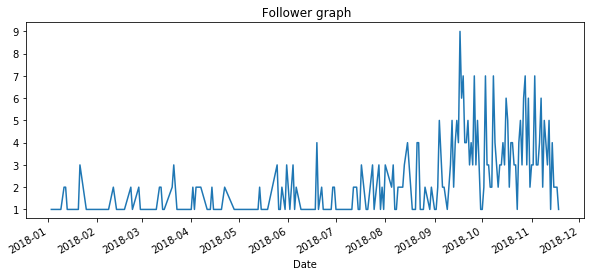

In [15]:
d.follower_timeplot(G,"STRIKER_OW")#where the graph is made

In [ ]:
print(d.common_follower(G)[:100])
print("amount of common followers: ",len(d.common_follower(G)))

In [51]:
d.popteam(G)

{'Boston Uprising': 'STRIKER_OW',
 'Dallas Fuel': 'DF_aKm',
 'Florida Myham': 'HAGOPEUN_OW',
 'Outlaws': 'LiNkzrOW',
 'London Spitfire': 'Birdring',
 'LA Glad': 'Hydration',
 'LA Val': 'Fate_ow',
 'New York Excel': 'saebyeolbe',
 'PHILADELPHIA FUSION': 'snillo_ow',
 'SAN FRANCISCO SHOCK': 'smurf_ow'}

In [23]:
d.find_most_popular_player(G)

'Apply'

In [11]:
d.group_con(G)

{'Boston Uprising': ['MickiePP', 'blaseOW'],
 'Dallas Fuel': ['Birdring',
  'Forceboink',
  'xepher123',
  'AnubhavKamath',
  'Hayesdot1',
  'xxxthewifebeat1',
  'ttx_ow',
  'Subzer0ow',
  'KwonJi98',
  'Arkham_KnightXD',
  'Soldanto_',
  'WillChin1',
  'SeverigeGaming',
  'Doppol_',
  'Queen3mma1',
  'Drastic347',
  'yodadaydreamer',
  'IsCornSafe',
  'zebraffe',
  'YJTGLOL',
  'Zethis99',
  'AmanSenna',
  'PupNoodles',
  'victor2mm',
  'Emanuel_P15',
  'hadodadi',
  'WestboundSon',
  'detonapotter',
  'TheOverNerds',
  'InkzOW',
  'Fogelscheuche',
  'DDruce3',
  'trenco_',
  'KarivOW',
  'AdamMonkey_',
  'pdxjenn13',
  'MarapLapgan',
  'QaykerPlus',
  'ThePauPascual',
  'TRIHARD2923920',
  'Kelthanos',
  'Eyes___XX',
  'DollaOw',
  '86Housecat',
  'Unknown72643755',
  'simmo_duck',
  'Unknown61684424',
  'this_is_raddish',
  'Djibouti_10',
  'AfkOW69',
  'CasCasty',
  'AngelusHerath',
  'huskylab11',
  'Enrikayy',
  'galerwen',
  'pphexea',
  'Oren_VH',
  'Dakureito',
  'goldyn_ow',
